In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
from google.colab import drive
import os
import numpy as np # Ensure numpy is imported
from sklearn.preprocessing import LabelEncoder

drive.mount("/content/drive")

def load_and_prepare_data():
    print("Loading data...")
    sequence_dir = '/content/drive/MyDrive/cremad_data_splits/'
    # Load data
    try:
        X = np.load(os.path.join(sequence_dir, 'mfcc_sequences.npy'))
        y_str = np.load(os.path.join(sequence_dir, 'mfcc_sequence_labels.npy'))
    except Exception as e:
        print(f"Error loading data from Google Drive: {e}")
        print(f"Please ensure the path '{sequence_dir}' is correct and Google Drive is mounted properly.")
        raise # Re-raise the exception so the user sees the original traceback

    print(f"Spectrograms shape: {X.shape}")
    print(f"Labels shape: {y_str.shape}")
    print(f"Unique emotions: {np.unique(y_str)}")

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)
    num_classes = len(label_encoder.classes_)

    print(f"Number of classes: {num_classes}")
    print(f"Class mapping: {dict(zip(label_encoder.classes_, range(num_classes)))}")

    return X, y, num_classes, label_encoder

Mounted at /content/drive


In [6]:
X,y, num_classes, label_encoder = load_and_prepare_data()

Loading data...
Spectrograms shape: (7442, 216, 13)
Labels shape: (7442,)
Unique emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Number of classes: 6
Class mapping: {np.str_('angry'): 0, np.str_('disgust'): 1, np.str_('fear'): 2, np.str_('happy'): 3, np.str_('neutral'): 4, np.str_('sad'): 5}


In [ ]:
# Visualize the distribution of emotional labels
plt.figure(figsize=(8, 6))
sns.countplot(x=y_str, order=np.unique(y_str))
plt.title('Distribution of Emotional Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of sequence lengths
sequence_lengths = [len(seq) for seq in X]
plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=50, kde=True)
plt.title('Distribution of MFCC Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

NameError: name 'y_str' is not defined

<Figure size 800x600 with 0 Axes>

In [7]:
# Split data
X, y, num_classes, label_encoder = load_and_prepare_data() # Load data using the updated function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
input_shape = (X_train.shape[1], X_train.shape[2])

Loading data...
Spectrograms shape: (7442, 216, 13)
Labels shape: (7442,)
Unique emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Number of classes: 6
Class mapping: {np.str_('angry'): 0, np.str_('disgust'): 1, np.str_('fear'): 2, np.str_('happy'): 3, np.str_('neutral'): 4, np.str_('sad'): 5}


In [8]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, label_encoder, model_display_name, epochs=80, batch_size=32):
    """Trains and evaluates a given model."""
    print(f"\nTraining model: {model_display_name}")

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

    # Removed the LRReducerCallback as requested


    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

    print("\nEvaluating model...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred = np.argmax(model.predict(X_test), axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    # Assuming label_encoder is available in the scope where this function is called
    # If not, you might need to pass it as an argument or retrieve it
    try:
        class_labels = label_encoder.classes_
    except NameError:
        print("Warning: label_encoder not found. Using default labels for confusion matrix.")
        class_labels = [str(i) for i in range(cm.shape[0])]


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


    return history, loss, accuracy

def plot_training_history(history, model_name):
    """Plots training and validation loss and accuracy."""
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
def build_lstm_model(input_shape, num_classes):
    """Builds an LSTM model."""
    model = Sequential([
        tf.keras.Input(shape=input_shape), # Add Input layer here
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Training model: LSTM_Model
Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1552 - loss: 1.7914 - val_accuracy: 0.1688 - val_loss: 1.7853 - learning_rate: 1.0000e-04
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2051 - loss: 1.7648 - val_accuracy: 0.2611 - val_loss: 1.7109 - learning_rate: 1.0000e-04
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3040 - loss: 1.6219 - val_accuracy: 0.3325 - val_loss: 1.5442 - learning_rate: 1.0000e-04
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3165 - loss: 1.5575 - val_accuracy: 0.3577 - val_loss: 1.5054 - learning_rate: 1.0000e-04
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3893 - loss: 1.4934 - val_accuracy: 0.3736 - val_loss: 1.4878 - learning_rate: 1.0000e-04
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3894 - loss: 1.4871 - val_accuracy: 0.4123 - val_loss: 1.4482 - learning_rate: 1.0000e-04
Epoch 7/80
149/149 ━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


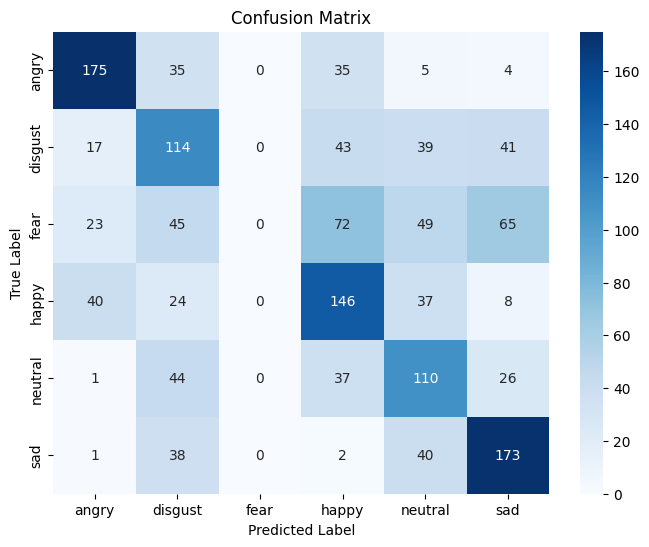

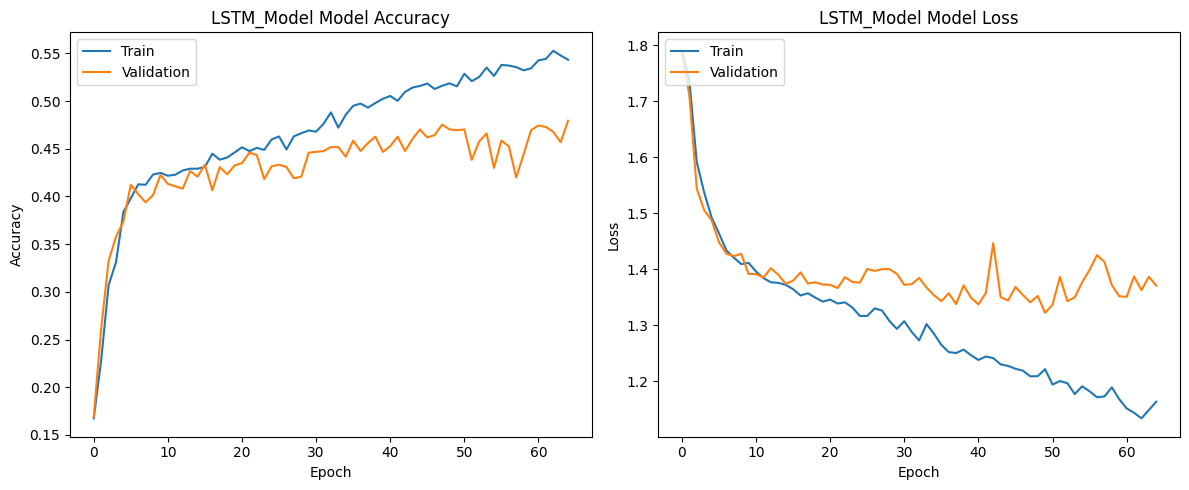

In [ ]:
lstm_model = build_lstm_model(input_shape, num_classes)
lstm_model._name = "LSTM_Model" # Assign a name for plotting

history_lstm, loss_lstm, accuracy_lstm = train_and_evaluate_model(lstm_model, X_train, y_train, X_test, y_test, label_encoder, "LSTM_Model")
plot_training_history(history_lstm, "LSTM_Model")


Training model: Bidirectional_LSTM_Model
Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.2184 - loss: 1.7741 - val_accuracy: 0.3392 - val_loss: 1.5958 - learning_rate: 1.0000e-04
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3434 - loss: 1.5603 - val_accuracy: 0.3711 - val_loss: 1.4860 - learning_rate: 1.0000e-04
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4063 - loss: 1.4654 - val_accuracy: 0.4190 - val_loss: 1.4318 - learning_rate: 1.0000e-04
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4228 - loss: 1.4135 - val_accuracy: 0.4274 - val_loss: 1.3961 - learning_rate: 1.0000e-04
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4306 - loss: 1.4009 - val_accuracy: 0.4400 - val_loss: 1.3857 - learning_rate: 1.0000e-04
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.4450 - loss: 1.3713 - val_accuracy: 0.4408 - val_loss: 1.3826 - learning_rate: 1.0000e-04
Epoch 7/80
149/

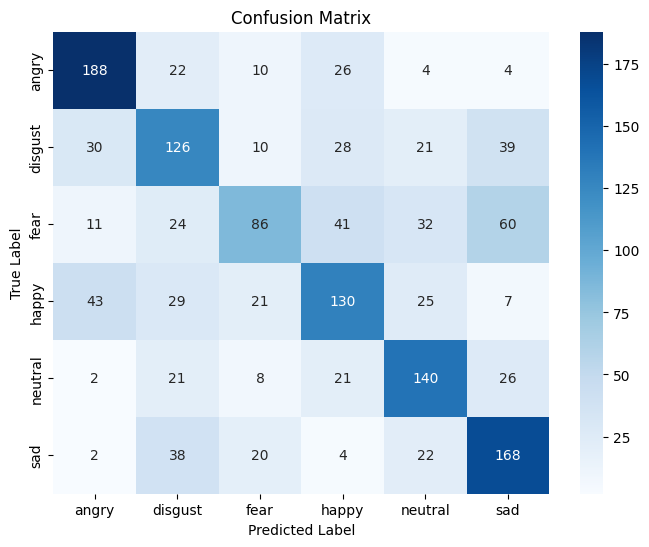

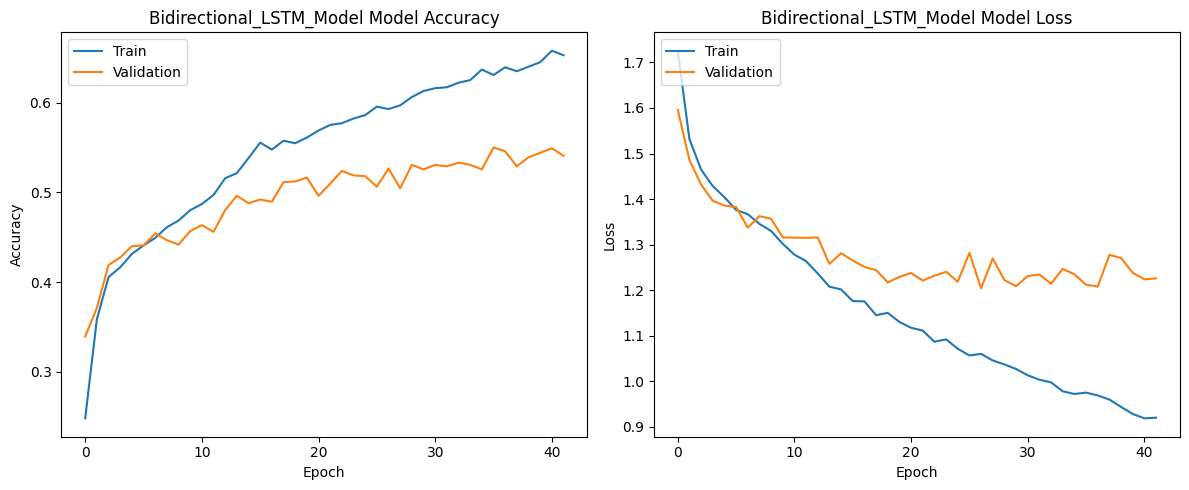

In [9]:
def build_bidirectional_lstm_model(input_shape, num_classes):
    """Builds a Bidirectional LSTM model."""
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

bidirectional_lstm_model = build_bidirectional_lstm_model(input_shape, num_classes)
bidirectional_lstm_model._name = "Bidirectional_LSTM_Model" # Assign a name for plotting

history_bidirectional_lstm, loss_bidirectional_lstm, accuracy_bidirectional_lstm = train_and_evaluate_model(bidirectional_lstm_model, X_train, y_train, X_test, y_test, label_encoder, "Bidirectional_LSTM_Model")
plot_training_history(history_bidirectional_lstm, "Bidirectional_LSTM_Model")


Training model: Reduced_Bidirectional_LSTM_Model
Epoch 1/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.1789 - loss: 1.8022 - val_accuracy: 0.2729 - val_loss: 1.7246 - learning_rate: 1.0000e-04
Epoch 2/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.2815 - loss: 1.7049 - val_accuracy: 0.3619 - val_loss: 1.5752 - learning_rate: 1.0000e-04
Epoch 3/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3612 - loss: 1.5698 - val_accuracy: 0.4123 - val_loss: 1.4854 - learning_rate: 1.0000e-04
Epoch 4/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.4072 - loss: 1.5011 - val_accuracy: 0.4072 - val_loss: 1.4646 - learning_rate: 1.0000e-04
Epoch 5/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4078 - loss: 1.4769 - val_accuracy: 0.4215 - val_loss: 1.4393 - learning_rate: 1.0000e-04
Epoch 6/80
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4007 - loss: 1.4681 - val_accuracy: 0.4114 - val_loss: 1.4352 - learning_rate: 1.0000e-04
Epoch 7/

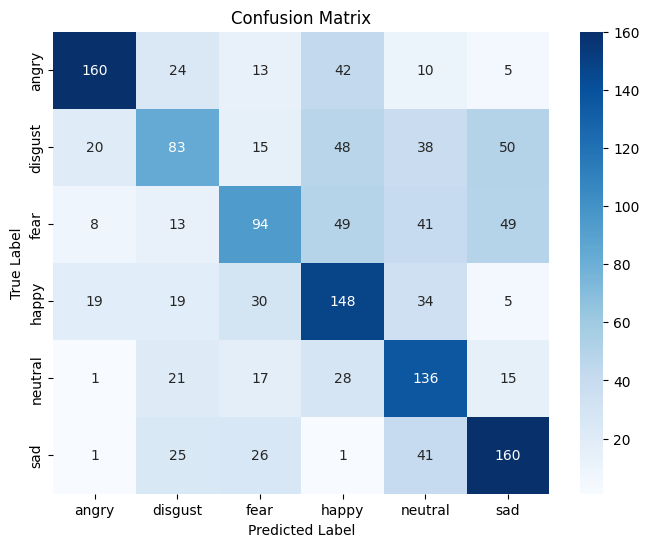

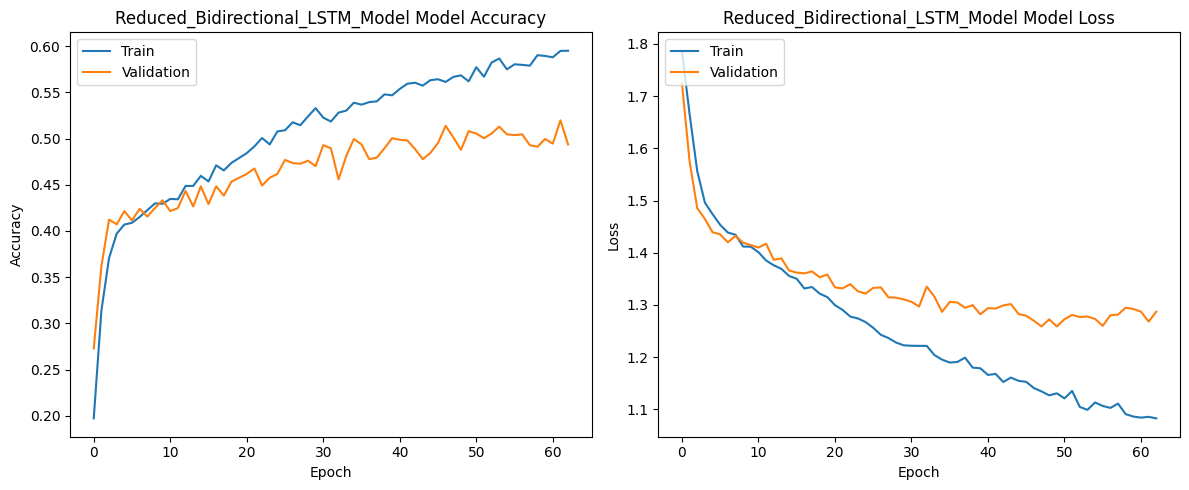

In [ ]:
def build_reduced_bidirectional_lstm_model(input_shape, num_classes):
    """Builds a Bidirectional LSTM model with reduced hidden layers."""
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Bidirectional(LSTM(64, return_sequences=True)), # Reduced units
        Dropout(0.3),
        Bidirectional(LSTM(32)), # Reduced units
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

reduced_bidirectional_lstm_model = build_reduced_bidirectional_lstm_model(input_shape, num_classes)
reduced_bidirectional_lstm_model._name = "Reduced_Bidirectional_LSTM_Model" # Assign a name for plotting

history_reduced_bidirectional_lstm, loss_reduced_bidirectional_lstm, accuracy_reduced_bidirectional_lstm = train_and_evaluate_model(reduced_bidirectional_lstm_model, X_train, y_train, X_test, y_test, label_encoder, "Reduced_Bidirectional_LSTM_Model")
plot_training_history(history_reduced_bidirectional_lstm, "Reduced_Bidirectional_LSTM_Model")

In [ ]:
import pandas as pd

data = {
    'Model': ["LSTM_Model", "Bidirectional_LSTM_Model", "Reduced_Bidirectional_LSTM_Model"],
    'Test Loss': [loss_lstm, loss_bidirectional_lstm, loss_reduced_bidirectional_lstm],
    'Test Accuracy': [accuracy_lstm, accuracy_bidirectional_lstm, accuracy_reduced_bidirectional_lstm]
}

comparison_df = pd.DataFrame(data)
display(comparison_df)

,Model,Test Loss,Test Accuracy
0,LSTM_Model,1.331218,0.482203
1,Bidirectional_LSTM_Model,1.202050,0.550705
2,Reduced_Bidirectional_LSTM_Model,1.258954,0.524513


Visualisations


In [ ]:
print("Loading data...")
sequence_dir = '/content/drive/MyDrive/cremad_data_splits/'
# Load data
try:
    X = np.load(os.path.join(sequence_dir, 'mfcc_sequences.npy'))
    y_str = np.load(os.path.join(sequence_dir, 'mfcc_sequence_labels.npy'))
except Exception as e:
    print(f"Error loading data from Google Drive: {e}")
    print(f"Please ensure the path '{sequence_dir}' is correct and Google Drive is mounted properly.")
    raise # Re-raise the exception so the user sees the original traceback

print(f"Spectrograms shape: {X.shape}")
print(f"Labels shape: {y_str.shape}")
print(f"Unique emotions: {np.unique(y_str)}")

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_str)
num_classes = len(label_encoder.classes_)

Loading data...
Spectrograms shape: (7442, 216, 13)
Labels shape: (7442,)
Unique emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


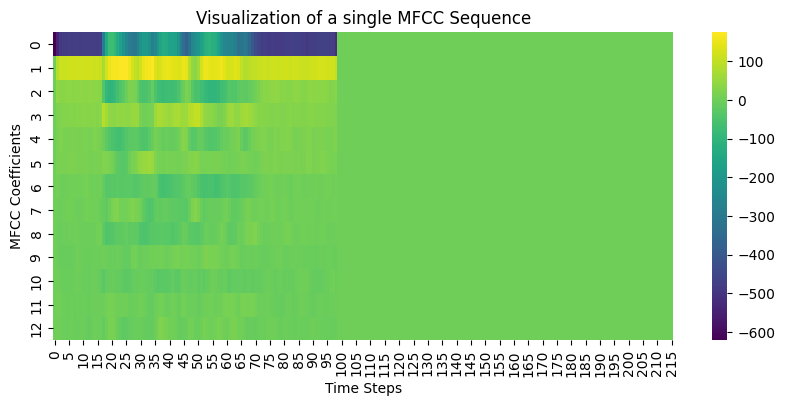

In [ ]:
# Visualize a single MFCC sequence
plt.figure(figsize=(10, 4))
sns.heatmap(X[0].T, cmap='viridis') # Transpose X[0] to have time on the x-axis and MFCC coefficients on the y-axis
plt.title('Visualization of a single MFCC Sequence')
plt.xlabel('Time Steps')
plt.ylabel('MFCC Coefficients')
plt.show()

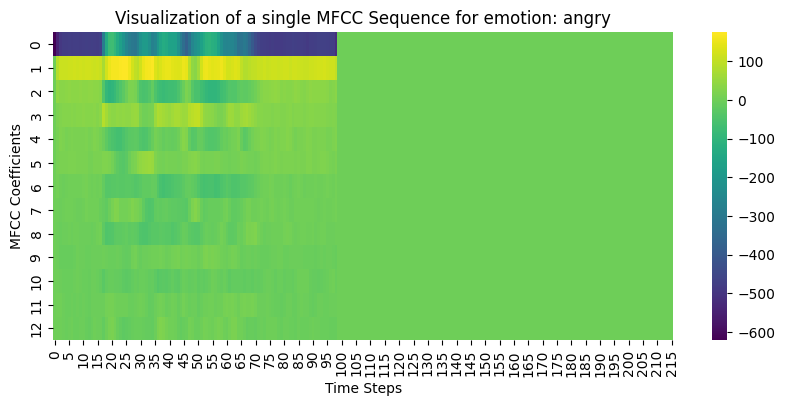

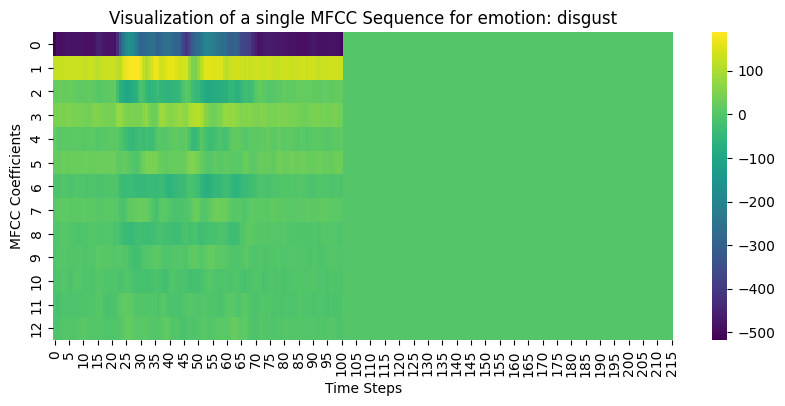

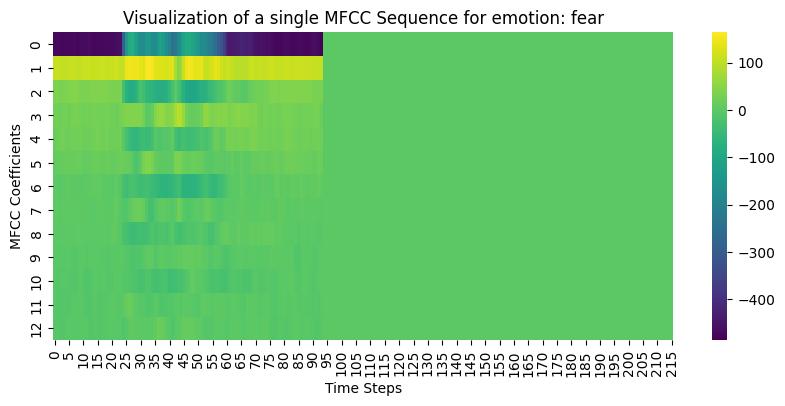

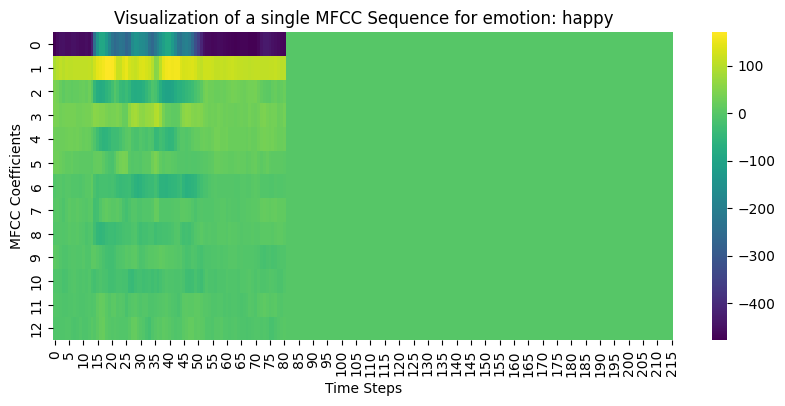

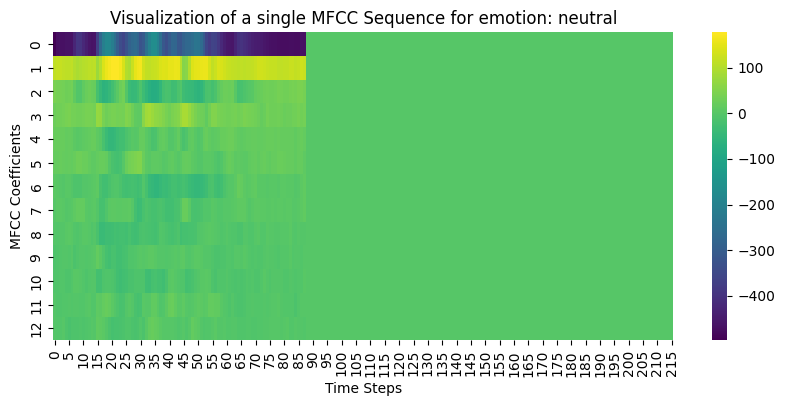

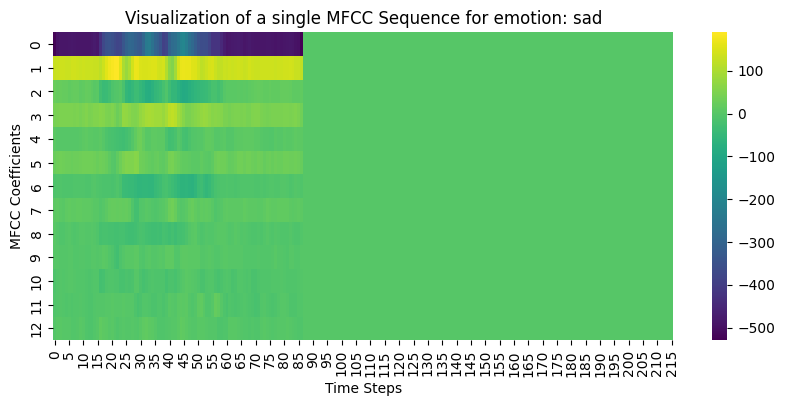

In [ ]:
# Get unique emotions and their corresponding indices
unique_emotions = np.unique(y_str)
emotion_indices = [np.where(y_str == emotion)[0][0] for emotion in unique_emotions]

# Visualize one MFCC sequence for each emotion
for i, emotion in enumerate(unique_emotions):
    plt.figure(figsize=(10, 4))
    sns.heatmap(X[emotion_indices[i]].T, cmap='viridis')
    plt.title(f'Visualization of a single MFCC Sequence for emotion: {emotion}')
    plt.xlabel('Time Steps')
    plt.ylabel('MFCC Coefficients')
    plt.show()

Loading data...
Spectrograms shape: (7442, 216, 13)
Labels shape: (7442,)
Unique emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Number of classes: 6
Class mapping: {np.str_('angry'): 0, np.str_('disgust'): 1, np.str_('fear'): 2, np.str_('happy'): 3, np.str_('neutral'): 4, np.str_('sad'): 5}


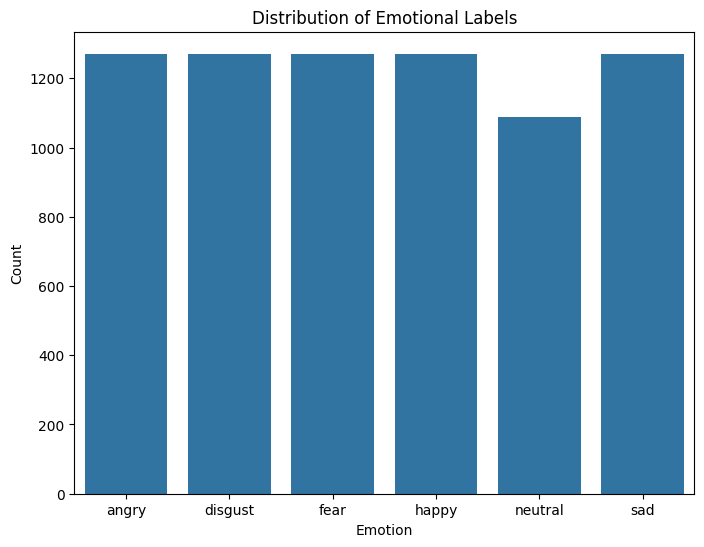

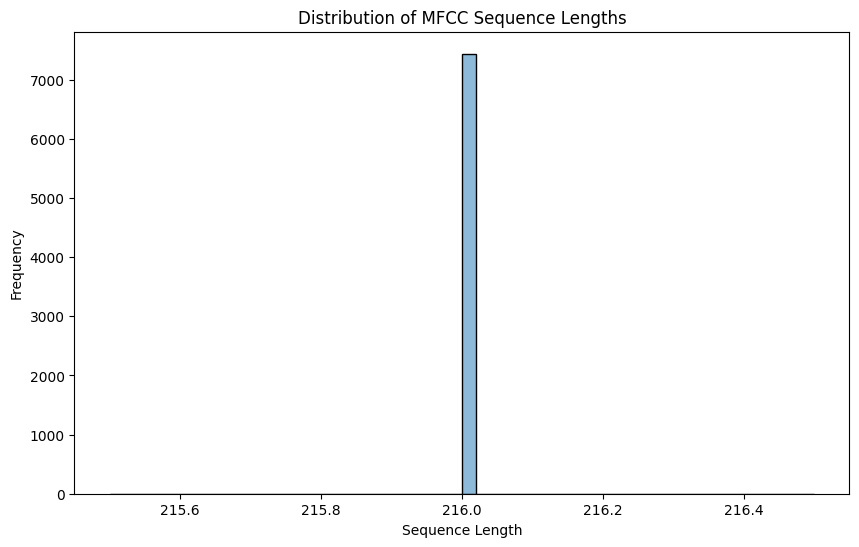

In [ ]:
# Load data for visualization
X, y, num_classes, label_encoder = load_and_prepare_data()

# Visualize the distribution of emotional labels
plt.figure(figsize=(8, 6))
sns.countplot(x=label_encoder.inverse_transform(y), order=np.unique(label_encoder.inverse_transform(y)))
plt.title('Distribution of Emotional Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of sequence lengths
sequence_lengths = [len(seq) for seq in X]
plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=50, kde=True)
plt.title('Distribution of MFCC Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
import librosa
import numpy as np
import tensorflow as tf


def preprocess_audio_for_prediction(audio_path, max_pad_len=216):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs = np.array(mfccs)

        # Pad or truncate to max_pad_len
        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        # Transpose to match the model's expected input shape (time_steps, n_mfcc)
        mfccs = mfccs.T

        # Add a batch dimension
        mfccs = np.expand_dims(mfccs, axis=0)

        return mfccs

    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

def predict_emotion(audio_path, model, label_encoder):
    """Predicts the emotion of a given audio file."""
    preprocessed_mfccs = preprocess_audio_for_prediction(audio_path)
    if preprocessed_mfccs is not None:
        predictions = model.predict(preprocessed_mfccs)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_emotion = label_encoder.inverse_transform([predicted_class_index])[0]
        confidence = np.max(predictions)
        return predicted_emotion, confidence
    else:
        return None, None

In [13]:
# Example usage:
# Replace "path/to/your/audio.wav" with the actual path to your audio file
audio_file_path = "/content/drive/MyDrive/cremad_data_splits/1001_DFA_ANG_XX.wav" # Example path, replace with your file

predicted_emotion, confidence = predict_emotion(audio_file_path, bidirectional_lstm_model, label_encoder)

if predicted_emotion:
    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Confidence: {confidence:.4f}")
else:
    print("Could not process audio file for prediction.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted Emotion: fear
Confidence: 0.7486
